In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('used_cars_data.csv')
df.drop_duplicates(inplace=True)
df.to_csv('usedCars_newData.csv', index=False)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 12235 entries, 0 to 16523
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 12235 non-null  object 
 1   MFG                   12235 non-null  int64  
 2   Mileage               12235 non-null  int64  
 3   Fuel                  12235 non-null  object 
 4   Transmission          12235 non-null  object 
 5   City                  12235 non-null  object 
 6   Listing_price (lacs)  12235 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 764.7+ KB


,MFG,Mileage,Listing_price (lacs)
count,12235.000000,1.223500e+04,12235.000000
mean,2017.871761,6.191950e+04,10.319991
std,3.605209,8.166799e+04,15.328413
min,1993.000000,1.010000e+02,0.250000
25%,2015.000000,3.526400e+04,4.140000
50%,2018.000000,5.700000e+04,6.210000
75%,2021.000000,8.000000e+04,10.390000
max,2025.000000,7.700000e+06,291.000000


In [106]:
# Checking for missing values

df.isnull().sum()

,0
Model,0
MFG,0
Mileage,0
Fuel,0
Transmission,0
City,0
Listing_price (lacs),0


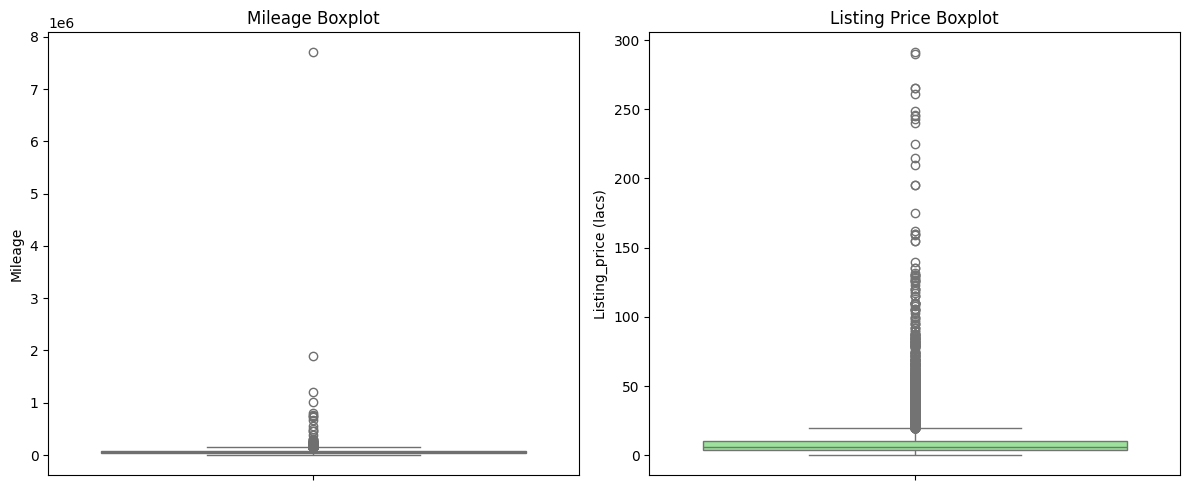

In [107]:
plt.figure(figsize=(12, 5))

# Boxplot for Mileage
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Mileage'], color='skyblue')
plt.title('Mileage Boxplot')

# Boxplot for Listing Price
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Listing_price (lacs)'], color='lightgreen')
plt.title('Listing Price Boxplot')

plt.tight_layout()
plt.show()

In [87]:
def range(df, feature):
    # Calculate Q1 and Q3
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR

    # Print the bounds
    print(f"{feature} -> Lower Bound: {lowerBound:.2f}, Upper Bound: {upperBound:.2f}")

range(df, 'Listing_price (lacs)')
range(df, 'Mileage')

Listing_price (lacs) -> Lower Bound: -5.24, Upper Bound: 19.77
Mileage -> Lower Bound: -31840.00, Upper Bound: 147104.00


In [91]:
df[df['Mileage'] > 200000].shape[0]

38

In [ ]:
# Since only 2.85% entries have mileage above its upper bound,
# we can remove those outliers as they might be simply errors in data (removal of outliers in Mileage)

In [92]:
# Removal of outliers in Mileage above 200000km
# 200000km is chosen so as to remove only truly extreme cases, keeping valuable & realistic data, and
# avoiding biasing the dataset against older but still valuable used cars

df_filtered = df[df["Mileage"] <= 200000].copy()

In [94]:
df_filtered[df_filtered['Listing_price (lacs)'] > 19.77].shape[0]

1182

In [133]:
# But for the price, 1182 entries have price above its upper bound,
# these must be entries of luxury cars therefore removal of these entries can affect the dataset as 9.69% of the data would have been removed.
# Therefore, to deal with this we will apply capping on price.

In [95]:
df_filtered[df_filtered['Listing_price (lacs)'] > 70].shape[0]

130

In [102]:
# We can see that capping at 19.77 affects ~10× more data than 70,
# and it may mislead models into thinking very different cars (e.g., BMW vs Maruti) have similar price
# Therefore capping at 70 is better bcoz it provides better data integrity, less distortion and preserves high-end pricing signals

df_filtered['Original_price (lacs)'] = df_filtered['Listing_price (lacs)']
df_filtered['Listing_price (lacs)'] = np.where(df_filtered['Original_price (lacs)'] > 70, 70, df_filtered['Original_price (lacs)'])

In [109]:
print(df['Fuel'].unique())
print(df['Transmission'].unique())

['Petrol' 'Diesel' 'CNG' 'Electric' 'LPG']
['Manual' 'Automatic']


In [132]:
# Since both Fuel and Transmission columns are already clean and have only valid unique values,
# standardization now simply means encoding them for modeling — i.e., converting them to numerical format which we will do later on.

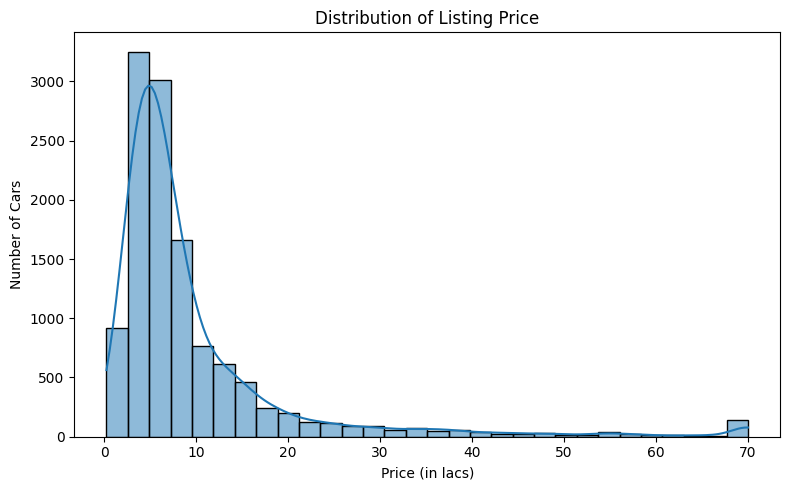

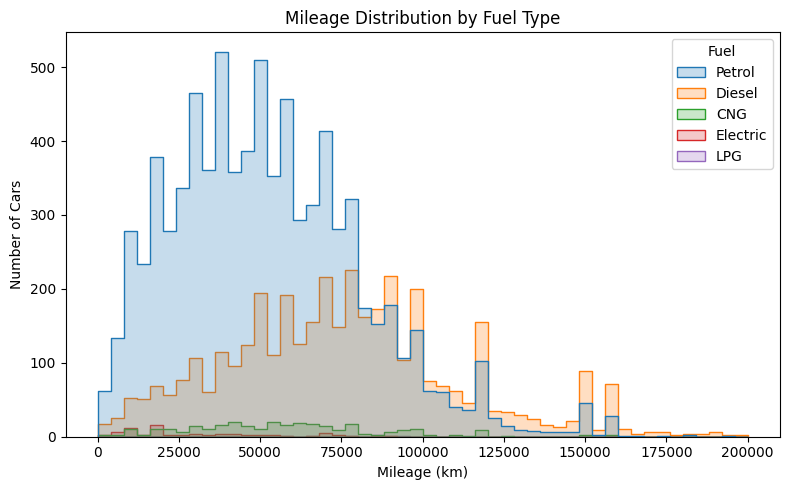

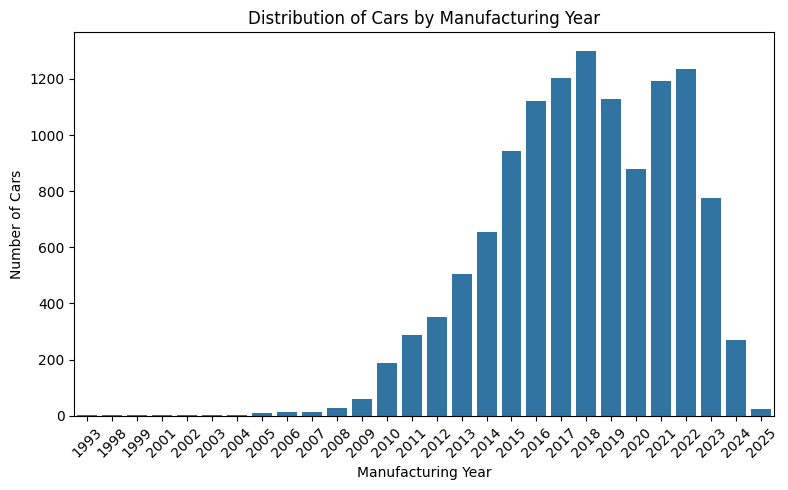

In [131]:
# Univariate Analysis

# Histogram of Listing Price
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered["Listing_price (lacs)"], bins=30, kde=True)
plt.title("Distribution of Listing Price")
plt.xlabel("Price (in lacs)")
plt.ylabel("Number of Cars")
plt.tight_layout()
plt.show()

# Histogram of Mileage by Fuel Type
plt.figure(figsize=(8, 5))
sns.histplot(data=df_filtered, x="Mileage", hue="Fuel", bins=50, element='step')
plt.title("Mileage Distribution by Fuel Type")
plt.xlabel("Mileage (km)")
plt.ylabel("Number of Cars")
plt.tight_layout()
plt.show()

# Year Distribution (Manufacturing Year)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x="MFG", order=sorted(df["MFG"].unique()))
plt.title("Distribution of Cars by Manufacturing Year")
plt.xlabel("Manufacturing Year")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [137]:
df_filtered['Brand'] = df_filtered['Model'].apply(lambda x: x.split()[0])

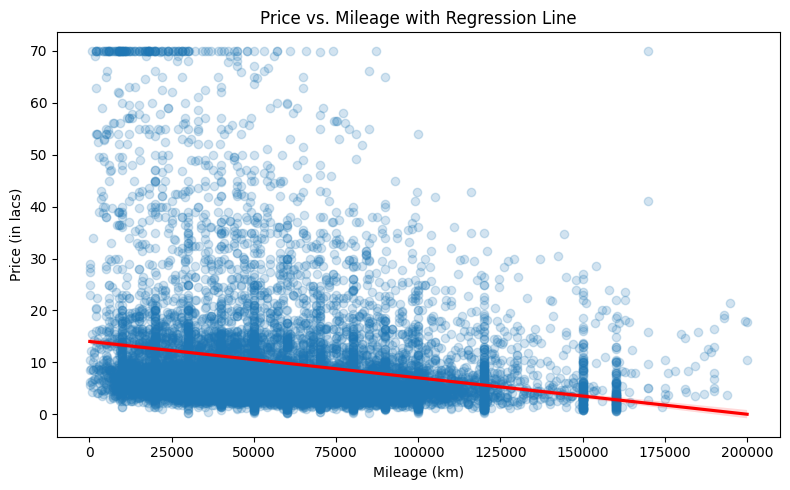

<ipython-input-171-6043d393e2ec>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x="Brand", y="Listing_price (lacs)", palette='pastel')


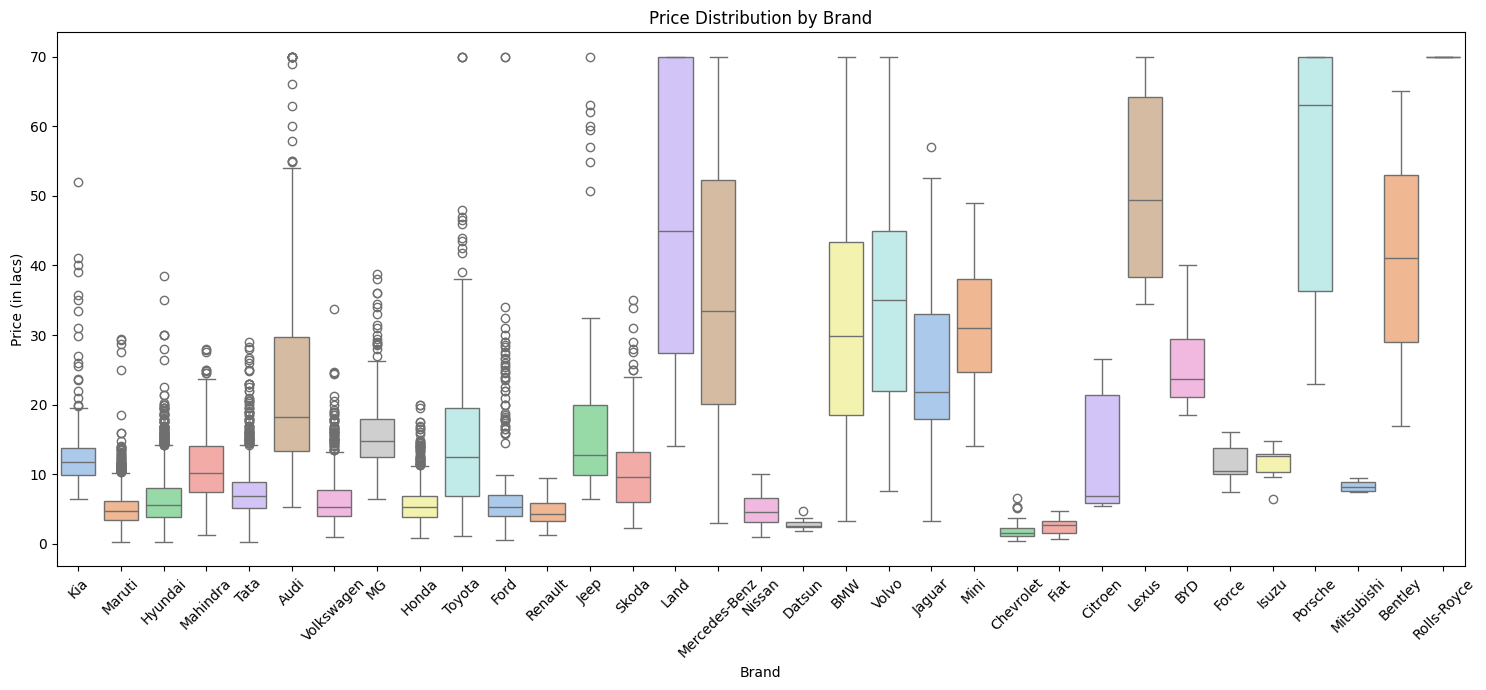

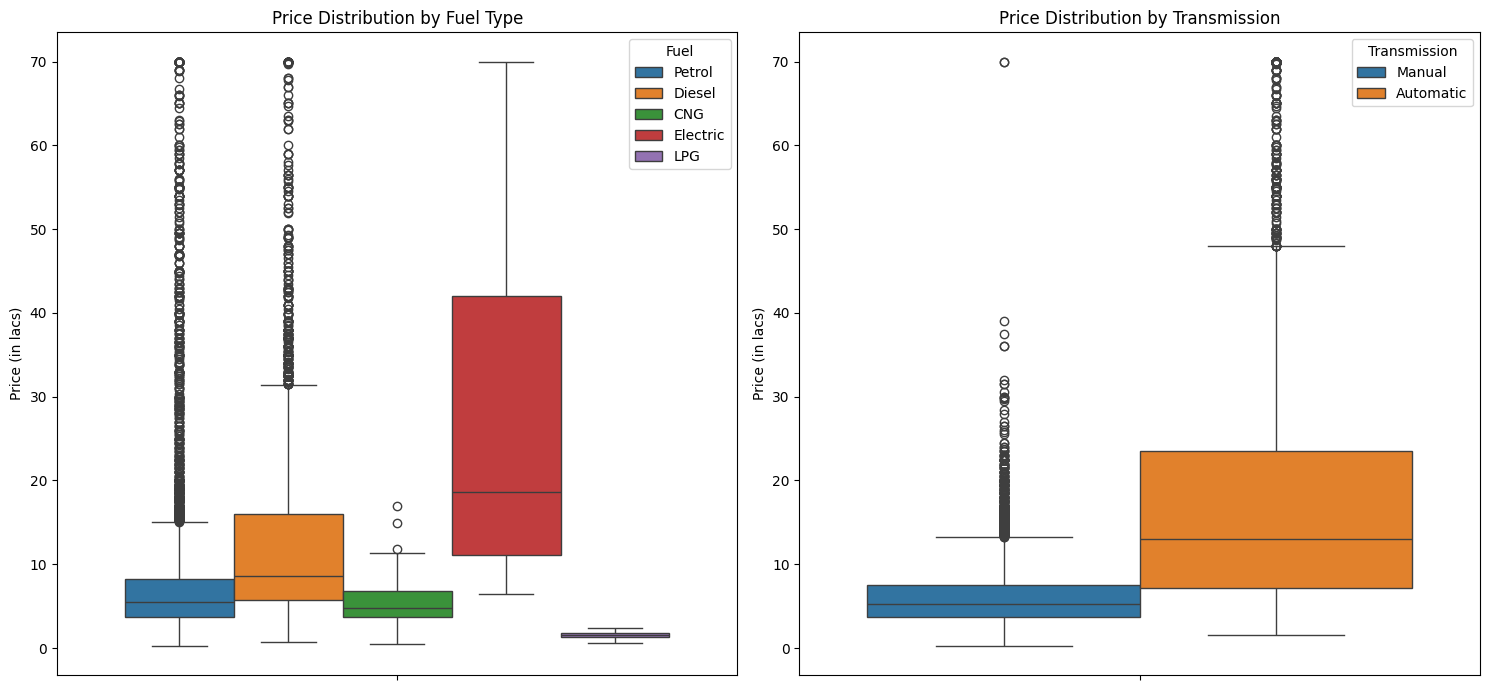

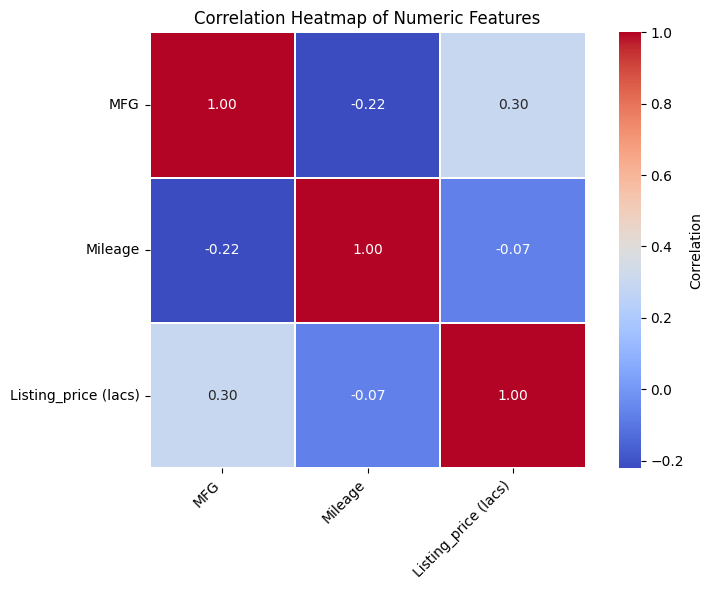

In [171]:
# Bivariate Analysis:

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(data=df_filtered, x="Mileage", y="Listing_price (lacs)", scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
plt.title("Price vs. Mileage with Regression Line")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (in lacs)")
plt.tight_layout()
plt.show()

# Boxplot of price by brand
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_filtered, x="Brand", y="Listing_price (lacs)", palette='pastel')
plt.title("Price Distribution by Brand")
plt.ylabel("Price (in lacs)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 7))

# Boxplot of price by fuel
plt.subplot(1,2,1)
sns.boxplot(data=df_filtered, hue="Fuel", y="Listing_price (lacs)")
plt.title("Price Distribution by Fuel Type")
plt.ylabel("Price (in lacs)")
plt.tight_layout()

# Boxplot of price by transmission
plt.subplot(1,2,2)
sns.boxplot(data=df_filtered, hue="Transmission", y="Listing_price (lacs)")
plt.title("Price Distribution by Transmission")
plt.ylabel("Price (in lacs)")
plt.tight_layout()
plt.show()

# Computing correlation matrix for numeric columns
corr = df.select_dtypes(include='number').corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.3, cbar_kws={"label": "Correlation"})
plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [191]:
# Feature Engineering

# Creating new features (namely, 'Age' & 'Price_per_km')
from datetime import datetime

current_year = datetime.now().year
df_filtered["Age"] = current_year - df_filtered["MFG"]
df_filtered["Price_per_km"] = df_filtered["Listing_price (lacs)"] / df_filtered["Mileage"].replace(0, pd.NA) # Avoiding division by '0'

# one-hot encoding
categorical_cols = ["Brand", "Fuel", "Transmission", "City"]
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True, dtype=int)
df_encoded.head()

# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Separating continuous numeric columns from binary dummy columns
continuous_cols = ['Listing_price (lacs)', 'MFG', 'Mileage', 'Age', 'Price_per_km', 'Original_price (lacs)']
df_scaled = df_encoded.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])

df_scaled.to_csv('Final_dataset_usedCars.csv', index=False)
df_scaled.sample(10)

,Model,MFG,Mileage,Listing_price (lacs),Original_price (lacs),Age,Price_per_km,Brand_BMW,Brand_BYD,Brand_Bentley,...,City_Faridabad,City_Ghaziabad,City_Gurgaon,City_Hyderabad,City_Jaipur,City_Mohali,City_New Delhi,City_Noida,City_Pune,City_Zirakpur
7879,Maruti Ertiga SHVS ZDI Plus,-0.523296,0.889745,-0.208335,-0.208335,0.523296,-0.079826,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2877,Mahindra XUV300 W8 Option Diesel BSVI,1.144496,-0.900318,0.194287,0.194287,-1.144496,-0.019895,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4244,Hyundai Xcent Petrol,-0.801261,0.159877,-0.473171,-0.473171,0.801261,-0.082486,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2911,Mahindra Thar LX Convert Top Diesel,1.700427,-0.900318,0.552173,0.552173,-1.700427,0.005339,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8208,Hyundai Creta 1.6 VTVT SX Plus,-0.523296,-0.727278,-0.304964,-0.304964,0.523296,-0.061658,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6555,Renault Pulse RxL,-1.357192,0.591401,-0.610957,-0.610957,1.357192,-0.088500,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5792,Hyundai Creta 1.4 CRDi S,-0.801261,1.099063,-0.253071,-0.253071,0.801261,-0.081942,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3058,Skoda Rapid 1.5 TDI Ambition BSIV,-0.245331,0.337093,-0.398015,-0.398015,0.245331,-0.081352,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15170,Hyundai i20 Sportz BSVI,0.866531,-0.959987,-0.230703,-0.230703,-0.866531,-0.046593,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4986,MG Hector Sharp Diesel MT,1.144496,-0.303630,0.641644,0.641644,-1.144496,-0.031250,0,0,0,...,0,0,0,0,0,0,0,0,0,0
